<a href="https://colab.research.google.com/github/mahdi13830510/ISIC-2018-challange-segmention-Using-Unet/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet Skin Lesion Segmentation on the ISIC 2018 Dataset

Skin lesion segmentation is a critical step in computer-aided dermatology. Accurate delineation of lesion boundaries helps downstream classifiers distinguish benign from malignant cases, and it reduces the subjectivity inherent in manual annotation.

This notebook implements a UNet from scratch in TensorFlow/Keras and trains it end-to-end on the ISIC 2018 Challenge Task 1 dataset. The full pipeline covers data exploration, augmentation, training with combined BCE + Dice loss, and a thorough quantitative and visual evaluation.

### What this notebook covers

1. **Data loading and exploration** -- understanding image dimensions, class balance, and lesion coverage before any modelling.
2. **Model definition** -- a standard UNet encoder-decoder with skip connections (filter sizes 32 through 512).
3. **Training** -- Adam optimizer with learning-rate scheduling, early stopping, and live metric tracking across 50 epochs.
4. **Evaluation** -- Dice, IoU, accuracy, precision, recall, and F1 computed on a held-out validation split.
5. **Visualisation** -- prediction overlays, error maps, confidence histograms, and training curves.

---

| Detail | Value |
|---|---|
| Dataset | ISIC 2018 Task 1 (Lesion Segmentation) |
| Architecture | UNet (32 - 64 - 128 - 256 - 512 bottleneck) |
| Loss | Binary Cross-Entropy + Dice Loss |
| Optimizer | Adam |

## 1. Imports and Configuration

All hyperparameters and file paths are collected in a single dictionary so that nothing is scattered across the notebook. If you are running this on Kaggle, the dataset is mounted under `/kaggle/input/` -- just make sure `image_dir` and `mask_dir` match the slug you have added to the notebook.

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json
import time
from datetime import datetime
from IPython.display import clear_output


CFG = {
    "patch_size":      512,
    "batch_size":      8,
    "epochs":          50,
    "learning_rate":   1e-4,
    "val_split":       0.2,
    "image_dir":       "/kaggle/input/datasets/tschandl/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input",
    "mask_dir":        "/kaggle/input/datasets/tschandl/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth",
    "output_dir":      "/kaggle/working",
    "seed":            42,
}

PATCH_SIZE  = CFG["patch_size"]
BATCH_SIZE  = CFG["batch_size"]
EPOCHS      = CFG["epochs"]
LR          = CFG["learning_rate"]
OUTPUT_DIR  = CFG["output_dir"]

os.makedirs(OUTPUT_DIR, exist_ok=True)

tf.random.set_seed(CFG["seed"])
np.random.seed(CFG["seed"])

gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow version : {tf.__version__}")
print(f"GPUs available     : {len(gpus)}")
if gpus:
    for g in gpus:
        print(f"  {g.name}")

print("\nConfiguration:")
for k, v in CFG.items():
    print(f"  {k:20s}: {v}")

2026-02-24 08:33:33.124310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771922013.303643      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771922013.355580      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771922013.788122      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771922013.788157      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771922013.788160      55 computation_placer.cc:177] computation placer alr

TensorFlow version : 2.19.0
GPUs available     : 1
  /physical_device:GPU:0

Configuration:
  patch_size          : 512
  batch_size          : 8
  epochs              : 50
  learning_rate       : 0.0001
  val_split           : 0.2
  image_dir           : /kaggle/input/datasets/tschandl/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input
  mask_dir            : /kaggle/input/datasets/tschandl/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth
  output_dir          : /kaggle/working
  seed                : 42


## 2. Exploratory Data Analysis

Before touching the model it is worth understanding the data we are working with. The cells below look at how many images and masks we have, what their spatial dimensions are, how much of each image the lesion actually occupies, and what a handful of representative samples look like. These observations directly inform the choice of input resolution, augmentation strategy, and loss function.

In [ ]:
image_dir = CFG["image_dir"]
mask_dir  = CFG["mask_dir"]

all_image_paths = sorted([os.path.join(image_dir, f)
                           for f in os.listdir(image_dir) if f.endswith(".jpg")])
all_mask_paths  = sorted([os.path.join(mask_dir,  f)
                           for f in os.listdir(mask_dir)  if f.endswith(".png")])

print(f"Total images : {len(all_image_paths)}")
print(f"Total masks  : {len(all_mask_paths)}")
assert len(all_image_paths) == len(all_mask_paths), "Mismatch between image and mask counts!"
print("Image-mask count matches.")

Total images : 2594
Total masks  : 2594
Image-mask count matches.


Sampling image stats from the first 50 images...


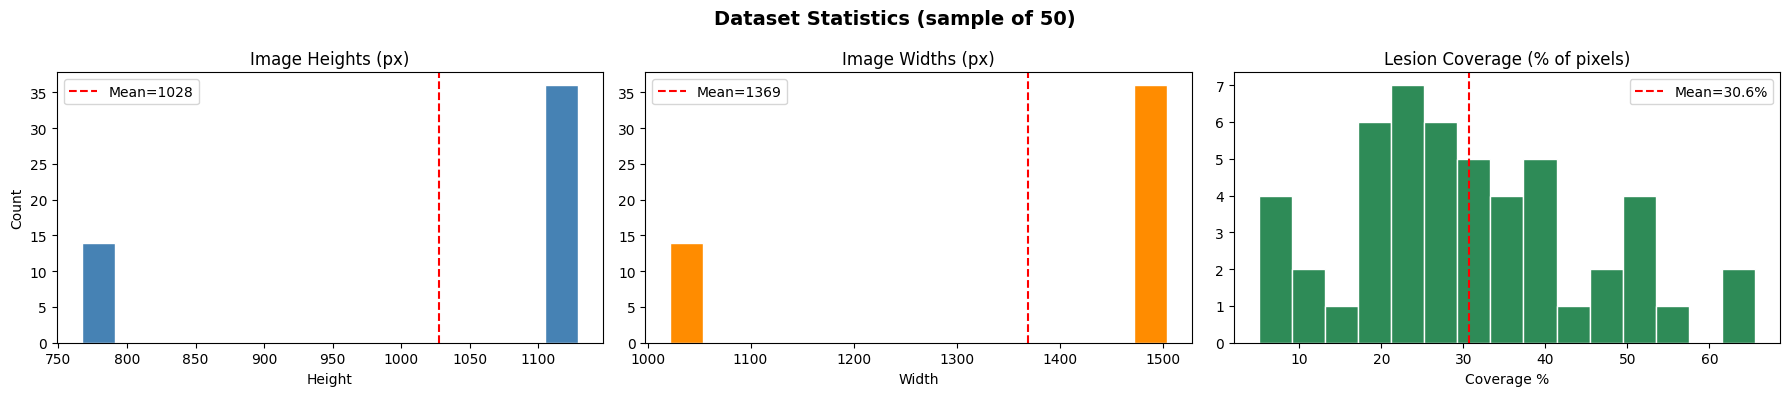


Summary:
  Avg height   : 1028px  (min=767, max=1129)
  Avg width    : 1369px  (min=1022, max=1504)
  Avg coverage : 30.6%  (min=5.0%, max=65.6%)


In [ ]:
print("Sampling image stats from the first 50 images...")
heights, widths, coverages = [], [], []

for img_p, msk_p in zip(all_image_paths[:-1], all_mask_paths[:-1]):
    img = cv2.imread(img_p)
    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)
    msk = cv2.imread(msk_p, cv2.IMREAD_GRAYSCALE)
    coverages.append((msk > 0).mean() * 100)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle("Dataset Statistics", fontsize=14, fontweight="bold")

axes[0].hist(heights, bins=15, color="steelblue", edgecolor="white")
axes[0].set_title("Image Heights (px)")
axes[0].set_xlabel("Height"); axes[0].set_ylabel("Count")
axes[0].axvline(np.mean(heights), color="red", linestyle="--",
                label=f"Mean={np.mean(heights):.0f}")
axes[0].legend()

axes[1].hist(widths, bins=15, color="darkorange", edgecolor="white")
axes[1].set_title("Image Widths (px)")
axes[1].set_xlabel("Width")
axes[1].axvline(np.mean(widths), color="red", linestyle="--",
                label=f"Mean={np.mean(widths):.0f}")
axes[1].legend()

axes[2].hist(coverages, bins=15, color="seagreen", edgecolor="white")
axes[2].set_title("Lesion Coverage (% of pixels)")
axes[2].set_xlabel("Coverage %")
axes[2].axvline(np.mean(coverages), color="red", linestyle="--",
                label=f"Mean={np.mean(coverages):.1f}%")
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "eda_stats.png"), dpi=150, bbox_inches="tight")
plt.show()

print(f"\nSummary:")
print(f"  Avg height   : {np.mean(heights):.0f}px  (min={min(heights)}, max={max(heights)})")
print(f"  Avg width    : {np.mean(widths):.0f}px  (min={min(widths)}, max={max(widths)})")
print(f"  Avg coverage : {np.mean(coverages):.1f}%  (min={min(coverages):.1f}%, max={max(coverages):.1f}%)")

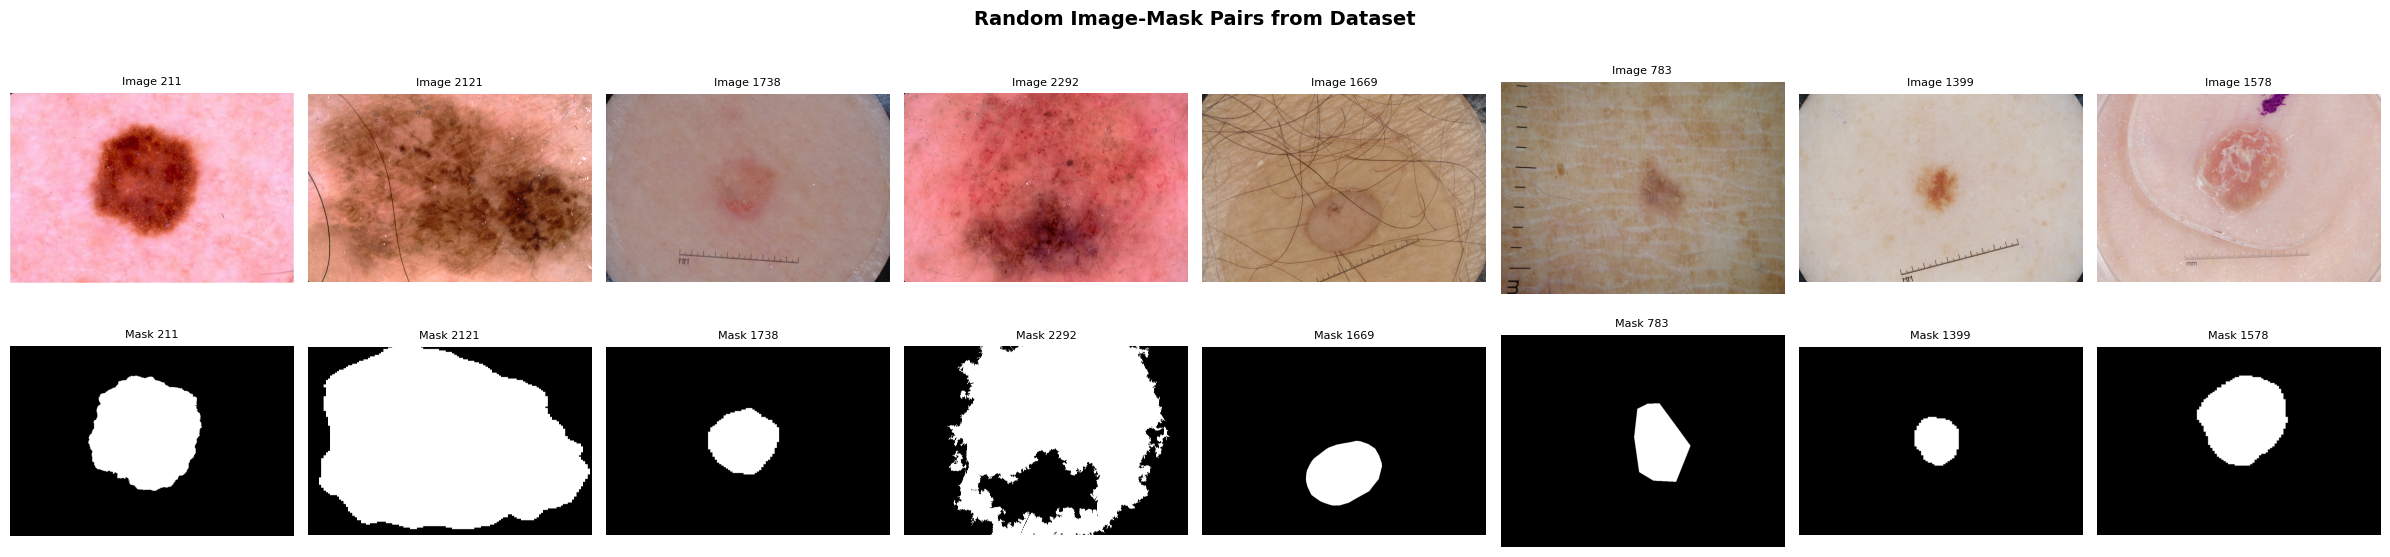

In [ ]:
indices = np.random.choice(len(all_image_paths), 8, replace=False)
fig, axes = plt.subplots(2, 8, figsize=(24, 6))
fig.suptitle("Random Image-Mask Pairs from Dataset", fontsize=14, fontweight="bold")

for col, idx in enumerate(indices):
    img = cv2.cvtColor(cv2.imread(all_image_paths[idx]), cv2.COLOR_BGR2RGB)
    msk = cv2.imread(all_mask_paths[idx], cv2.IMREAD_GRAYSCALE)

    axes[0, col].imshow(img)
    axes[0, col].set_title(f"Image {idx}", fontsize=8)
    axes[0, col].axis("off")

    axes[1, col].imshow(msk, cmap="gray")
    axes[1, col].set_title(f"Mask {idx}", fontsize=8)
    axes[1, col].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "eda_samples.png"), dpi=120, bbox_inches="tight")
plt.show()

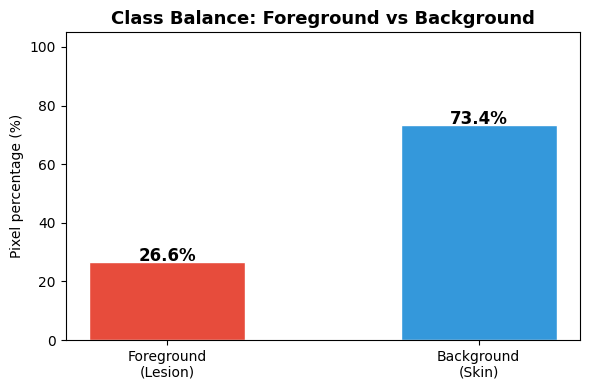

Foreground: 26.6%   Background: 73.4%
Note: Class imbalance favors using Dice Loss or weighted BCE.


In [ ]:
fg_pixels, bg_pixels = 0, 0
for msk_p in all_mask_paths[:100]:
    msk = cv2.imread(msk_p, cv2.IMREAD_GRAYSCALE)
    fg_pixels += (msk > 0).sum()
    bg_pixels += (msk == 0).sum()

total  = fg_pixels + bg_pixels
fg_pct = 100 * fg_pixels / total
bg_pct = 100 * bg_pixels / total

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(
    ["Foreground\n(Lesion)", "Background\n(Skin)"],
    [fg_pct, bg_pct],
    color=["#e74c3c", "#3498db"], edgecolor="white", width=0.5
)
for bar, pct in zip(bars, [fg_pct, bg_pct]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{pct:.1f}%", ha="center", fontsize=12, fontweight="bold")
ax.set_ylim(0, 105)
ax.set_ylabel("Pixel percentage (%)")
ax.set_title("Class Balance: Foreground vs Background", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "eda_class_balance.png"), dpi=150, bbox_inches="tight")
plt.show()

print(f"Foreground: {fg_pct:.1f}%   Background: {bg_pct:.1f}%")
print("Note: Class imbalance favors using Dice Loss or weighted BCE.")

## 3. Model Architecture

The model follows the classic UNet layout introduced by Ronneberger et al. (2015). The encoder progressively downsamples the input through four stages of double convolutions followed by max-pooling, producing increasingly abstract feature maps. At the bottom sits a 512-channel bottleneck. The decoder then mirrors the encoder, using transposed convolutions to upsample and skip connections to recover fine spatial detail lost during downsampling.

Filter progression through the network: `3 (input) -> 32 -> 64 -> 128 -> 256 -> 512 (bottleneck) -> ... -> 1 (output sigmoid)`.

In [ ]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block(x, filters):
    skip = conv_block(x, filters)
    pool = layers.MaxPooling2D((2, 2))(skip)
    return skip, pool

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(512, 512, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bottleneck
    b = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b,  s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid", dtype="float32")(d4)
    return models.Model(inputs, outputs, name="UNet")

model = build_unet(input_shape=(PATCH_SIZE, PATCH_SIZE, 3))
model.summary(line_length=80)
print(f"\nTotal parameters: {model.count_params():,}")

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape      ┃     Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1         │ (None, 512, 512,  │           0 │ -                  │
│ (InputLayer)          │ 3)                │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ conv2d_19 (Conv2D)    │ (None, 512, 512,  │         896 │ input_layer_1[0][… │
│                       │ 32)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ batch_normalization_… │ (None, 512, 512,  │         128 │ conv2d_19[0][0]    │
│ (BatchNormalization)  │ 32)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ activation_18         │ (None, 512, 512,  │           0 │ batch_normalizati… │
│ (Activation)          │ 32)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ conv2d_20 (Conv2D)    │ (None, 512, 512,  │       9,248 │ activation_18[0][… │
│                       │ 32)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ batch_normalization_… │ (None, 512, 512,  │         128 │ conv2d_20[0][0]    │
│ (BatchNormalization)  │ 32)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ activation_19         │ (None, 512, 512,  │           0 │ batch_normalizati… │
│ (Activation)          │ 32)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ max_pooling2d_4       │ (None, 256, 256,  │           0 │ activation_19[0][… │
│ (MaxPooling2D)        │ 32)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ conv2d_21 (Conv2D)    │ (None, 256, 256,  │      18,496 │ max_pooling2d_4[0… │
│                       │ 64)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ batch_normalization_… │ (None, 256, 256,  │         256 │ conv2d_21[0][0]    │
│ (BatchNormalization)  │ 64)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ activation_20         │ (None, 256, 256,  │           0 │ batch_normalizati… │
│ (Activation)          │ 64)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ conv2d_22 (Conv2D)    │ (None, 256, 256,  │      36,928 │ activation_20[0][… │
│                       │ 64)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ batch_normalization_… │ (None, 256, 256,  │         256 │ conv2d_22[0][0]    │
│ (BatchNormalization)  │ 64)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ activation_21         │ (None, 256, 256,  │           0 │ batch_normalizati… │
│ (Activation)          │ 64)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ max_pooling2d_5       │ (None, 128, 128,  │           0 │ activation_21[0][… │
│ (MaxPooling2D)        │ 64)               │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ conv2d_23 (Conv2D)    │ (None, 128, 128,  │      73,856 │ max_pooling2d_5[0… │
│                       │ 128) 

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)


Total parameters: 7,771,873


## 4. Loss Functions and Metrics

Class imbalance is a known challenge in medical image segmentation -- in many samples the lesion covers only a small fraction of the image, so a naive pixel-wise cross-entropy would be dominated by the background class. To address this we combine two complementary losses:

$$\mathcal{L} = \text{BCE} + (1 - \text{Dice})$$

Binary cross-entropy penalises individual pixel misclassifications, while Dice loss directly optimises the overlap between prediction and ground truth. The combination gives the optimiser a per-pixel gradient signal and a region-level signal at the same time.

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1.0 - (2.0 * intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce  = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.reduce_mean(bce) + dice

def dice_coef_metric(y_true, y_pred, smooth=1e-6):
    """Dice coefficient as a Keras metric, thresholded at 0.5."""
    y_pred_bin    = tf.cast(y_pred > 0.5, tf.float32)
    intersection  = tf.reduce_sum(y_true * y_pred_bin)
    union         = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin)
    return (2.0 * intersection + smooth) / (union + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    """Intersection-over-Union as a Keras metric, thresholded at 0.5."""
    y_pred_bin   = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union        = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    return (intersection + smooth) / (union + smooth)

print("Loss and metric functions defined.")

Loss and metric functions defined.


## 5. Data Pipeline

An efficient `tf.data` pipeline handles all preprocessing:

- **Normalisation** -- pixel values are rescaled from [0, 255] to [0, 1].
- **Resizing** -- every image and mask is resized to the configured `PATCH_SIZE` (512 x 512 here).
- **Augmentation (training only)** -- random horizontal and vertical flips, brightness jitter, and contrast jitter add variety without changing the label semantics.
- **Prefetching** -- CPU preprocessing is overlapped with GPU execution so neither sits idle waiting for the other.

In [ ]:
def load_image_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask > 0, tf.float32)
    return image, mask

def preprocess_val(image_path, mask_path):
    image, mask = load_image_mask(image_path, mask_path)
    image = tf.image.resize_with_crop_or_pad(image, PATCH_SIZE, PATCH_SIZE)
    mask  = tf.image.resize_with_crop_or_pad(mask,  PATCH_SIZE, PATCH_SIZE)
    return image, mask

def preprocess_train(image_path, mask_path):
    image, mask = load_image_mask(image_path, mask_path)
    image = tf.image.resize_with_crop_or_pad(image, PATCH_SIZE, PATCH_SIZE)
    mask  = tf.image.resize_with_crop_or_pad(mask,  PATCH_SIZE, PATCH_SIZE)

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask  = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask  = tf.image.flip_up_down(mask)

    # Random brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, mask

def make_dataset(image_paths, mask_paths, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    preprocess_fn = preprocess_train if augment else preprocess_val
    ds = ds.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.shuffle(buffer_size=200, seed=CFG["seed"])
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Train / Val split
n       = len(all_image_paths)
split   = int((1 - CFG["val_split"]) * n)
idx_all = np.arange(n)
np.random.shuffle(idx_all)

train_idx = idx_all[:split]
val_idx   = idx_all[split:]

train_images = [all_image_paths[i] for i in train_idx]
train_masks  = [all_mask_paths[i]  for i in train_idx]
val_images   = [all_image_paths[i] for i in val_idx]
val_masks    = [all_mask_paths[i]  for i in val_idx]

train_ds = make_dataset(train_images, train_masks, augment=True)
val_ds   = make_dataset(val_images,   val_masks,   augment=False)

print(f"Training   samples : {len(train_images)}  ({len(list(train_ds))} batches)")
print(f"Validation samples : {len(val_images)}  ({len(list(val_ds))} batches)")

Training   samples : 2075  (260 batches)
Validation samples : 519  (65 batches)


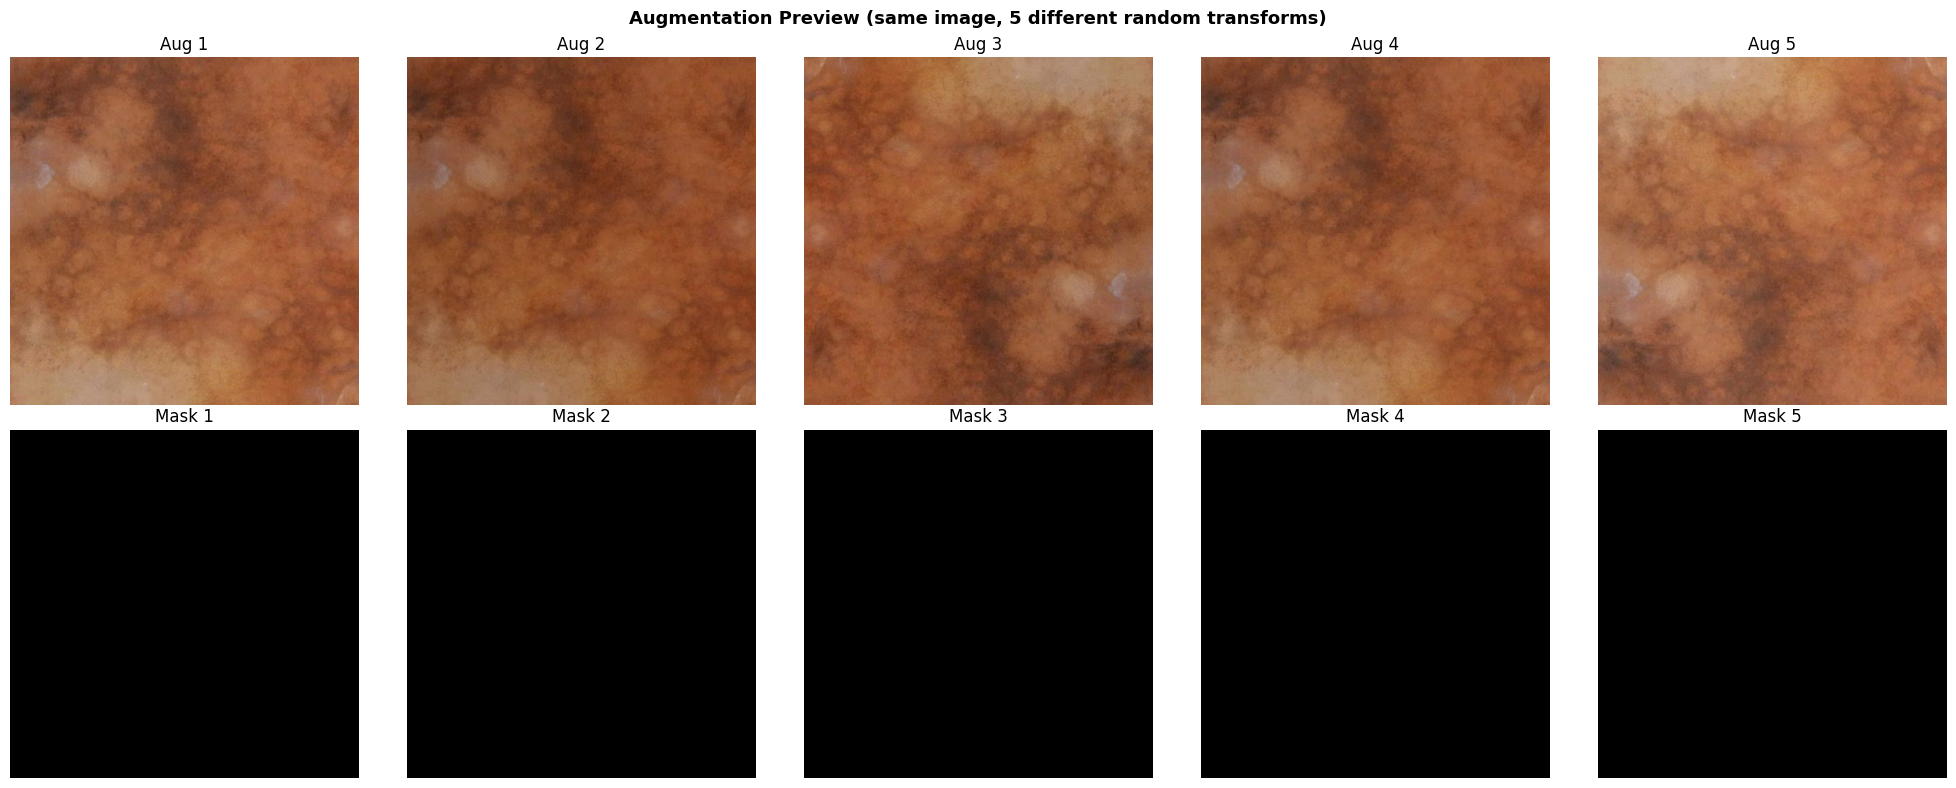

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Augmentation Preview (same image, 5 different random transforms)",
             fontsize=13, fontweight="bold")

for col in range(5):
    img, msk = preprocess_train(train_images[0], train_masks[0])
    axes[0, col].imshow(img.numpy())
    axes[0, col].set_title(f"Aug {col+1}"); axes[0, col].axis("off")
    axes[1, col].imshow(msk.numpy()[:, :, 0], cmap="gray")
    axes[1, col].set_title(f"Mask {col+1}"); axes[1, col].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "augmentation_preview.png"), dpi=120, bbox_inches="tight")
plt.show()

## 6. Training Setup

Five callbacks control the training loop:

- **ModelCheckpoint** saves the weights whenever validation Dice improves, so the best model is always available regardless of when training ends.
- **EarlyStopping** terminates training if validation Dice has not improved for 10 consecutive epochs, then restores the best weights automatically.
- **ReduceLROnPlateau** halves the learning rate when validation loss stalls for 5 epochs, giving the optimiser a chance to escape shallow local minima.
- **CSVLogger** writes every metric to disk after each epoch for later analysis.
- **LivePlotCallback** is a custom callback that prints a compact metric table and refreshes inline training curves after every epoch.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(
    optimizer=optimizer,
    loss=bce_dice_loss,
    metrics=[
        dice_coef_metric,
        iou_metric,
        tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5),
        tf.keras.metrics.Precision(name="precision", thresholds=0.5),
        tf.keras.metrics.Recall(name="recall", thresholds=0.5),
    ]
)
print("Model compiled.")

Model compiled.


In [ ]:
class LivePlotCallback(tf.keras.callbacks.Callback):
    """Prints a per-epoch metric table and refreshes training curve plots inline."""

    def __init__(self):
        super().__init__()
        self.history = {
            "epoch":            [],
            "loss":             [], "val_loss":             [],
            "dice_coef_metric": [], "val_dice_coef_metric": [],
            "iou_metric":       [], "val_iou_metric":       [],
            "accuracy":         [], "val_accuracy":         [],
            "precision":        [], "val_precision":        [],
            "recall":           [], "val_recall":           [],
            "lr":               [],
        }

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        e = epoch + 1
        self.history["epoch"].append(e)

        for key in self.history:
            if key == "epoch":
                continue
            elif key == "lr":
                self.history["lr"].append(float(self.model.optimizer.learning_rate))
            else:
                self.history[key].append(logs.get(key, np.nan))

        # Compact per-epoch table
        print(f"\n{'-'*70}")
        print(f" Epoch {e:3d}/{EPOCHS}")
        print(f"  {'Metric':<22} {'Train':>10} {'Val':>10}")
        print(f"  {'-'*42}")
        for label, tk, vk in [
            ("Loss (BCE+Dice)",  "loss",             "val_loss"),
            ("Dice Coeff",       "dice_coef_metric", "val_dice_coef_metric"),
            ("IoU",              "iou_metric",        "val_iou_metric"),
            ("Accuracy",         "accuracy",          "val_accuracy"),
            ("Precision",        "precision",         "val_precision"),
            ("Recall",           "recall",            "val_recall"),
        ]:
            t = logs.get(tk, float('nan'))
            v = logs.get(vk, float('nan'))
            print(f"  {label:<22} {t:>10.4f} {v:>10.4f}")
        print(f"  LR: {float(self.model.optimizer.learning_rate):.2e}")
        print(f"{'-'*70}")

        # Skip plot for first epoch (need at least 2 points)
        if len(self.history["epoch"]) < 2:
            return

        clear_output(wait=True)
        epochs_range = self.history["epoch"]

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f"Training Progress - Epoch {e}/{EPOCHS}",
                     fontsize=15, fontweight="bold")

        for ax, tk, vk, title, ylabel in [
            (axes[0,0], "loss",             "val_loss",             "Combined Loss (BCE+Dice)", "Loss"),
            (axes[0,1], "dice_coef_metric", "val_dice_coef_metric", "Dice Coefficient",         "Dice"),
            (axes[0,2], "iou_metric",        "val_iou_metric",       "Intersection over Union",  "IoU"),
            (axes[1,0], "accuracy",          "val_accuracy",          "Pixel Accuracy",           "Accuracy"),
            (axes[1,1], "precision",         "val_precision",         "Precision",                "Precision"),
            (axes[1,2], "recall",            "val_recall",            "Recall",                   "Recall"),
        ]:
            ax.plot(epochs_range, self.history[tk], label="Train",
                    color="steelblue", linewidth=2, marker="o", markersize=3)
            ax.plot(epochs_range, self.history[vk], label="Val",
                    color="tomato", linewidth=2, marker="s", markersize=3, linestyle="--")
            ax.set_title(title, fontsize=11, fontweight="bold")
            ax.set_xlabel("Epoch"); ax.set_ylabel(ylabel)
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlim(1, max(epochs_range))

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "training_curves.png"), dpi=120, bbox_inches="tight")
        plt.show()


live_plot_cb = LivePlotCallback()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(OUTPUT_DIR, "best_model.h5"),
    monitor="val_dice_coef_metric",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coef_metric",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

reducelr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

csv_logger_cb = tf.keras.callbacks.CSVLogger(
    os.path.join(OUTPUT_DIR, "training_log.csv"),
    append=False,
)

all_callbacks = [
    live_plot_cb,
    checkpoint_cb,
    earlystop_cb,
    reducelr_cb,
    csv_logger_cb,
]
print("All callbacks configured.")

All callbacks configured.


## 7. Training

Training runs for up to 50 epochs. After each epoch the six tracked metrics (loss, Dice, IoU for both train and validation) are logged to the CSV file and printed as a table. A live 6-panel plot is refreshed inline so that convergence behaviour is visible without waiting for training to finish.

If validation loss plateaus the learning rate is automatically reduced, and if validation Dice stops improving altogether early stopping kicks in and rolls the model back to its best checkpoint.

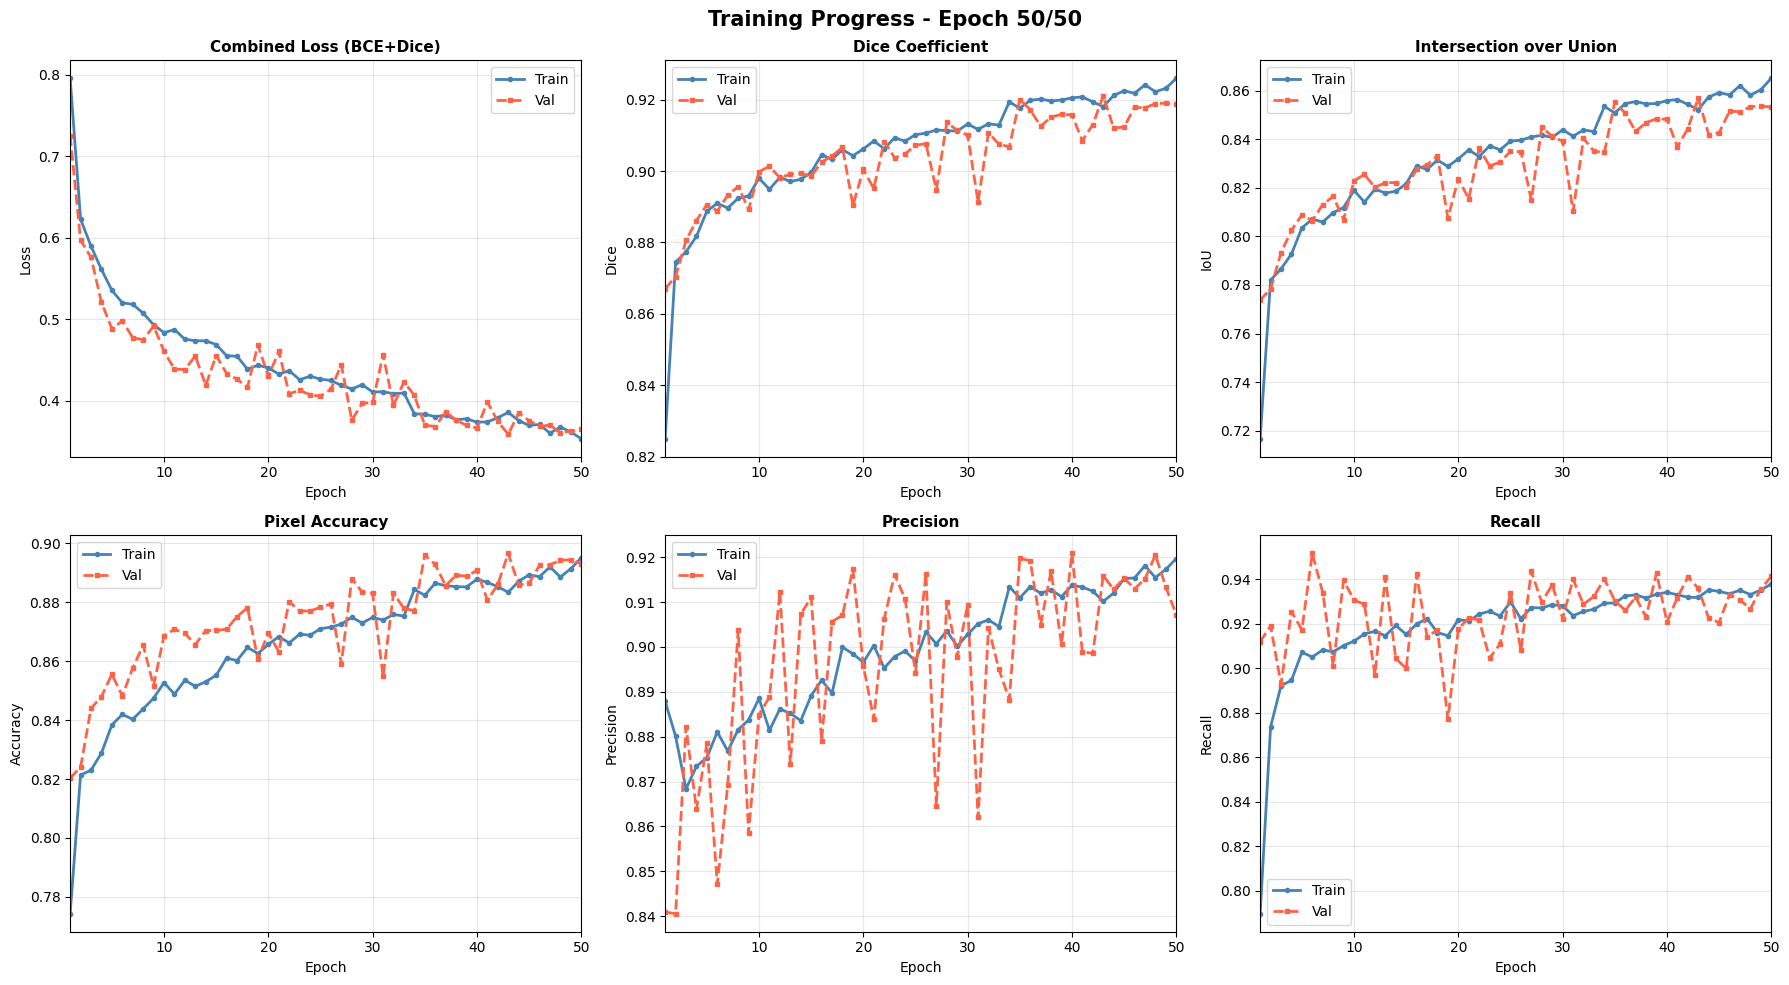


Epoch 50: val_dice_coef_metric did not improve from 0.92109
Restoring model weights from the end of the best epoch: 43.

Training complete. Total time: 259.0 min


In [ ]:
start_time = time.time()
print(f"Training started at {datetime.now().strftime('%H:%M:%S')}")
print(f"Epochs: {EPOCHS} | Batch size: {BATCH_SIZE} | LR: {LR}\n")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=all_callbacks,
    verbose=0,   # per-epoch output is handled by LivePlotCallback
)

elapsed = time.time() - start_time
print(f"\nTraining complete. Total time: {elapsed/60:.1f} min")

## 8. Post-Training Curves

With training complete, the cells below produce static versions of the metric curves covering the full run. An additional "overfitting monitor" plot shows the gap between training and validation performance over time -- a widening gap would indicate the model is memorising rather than generalising.

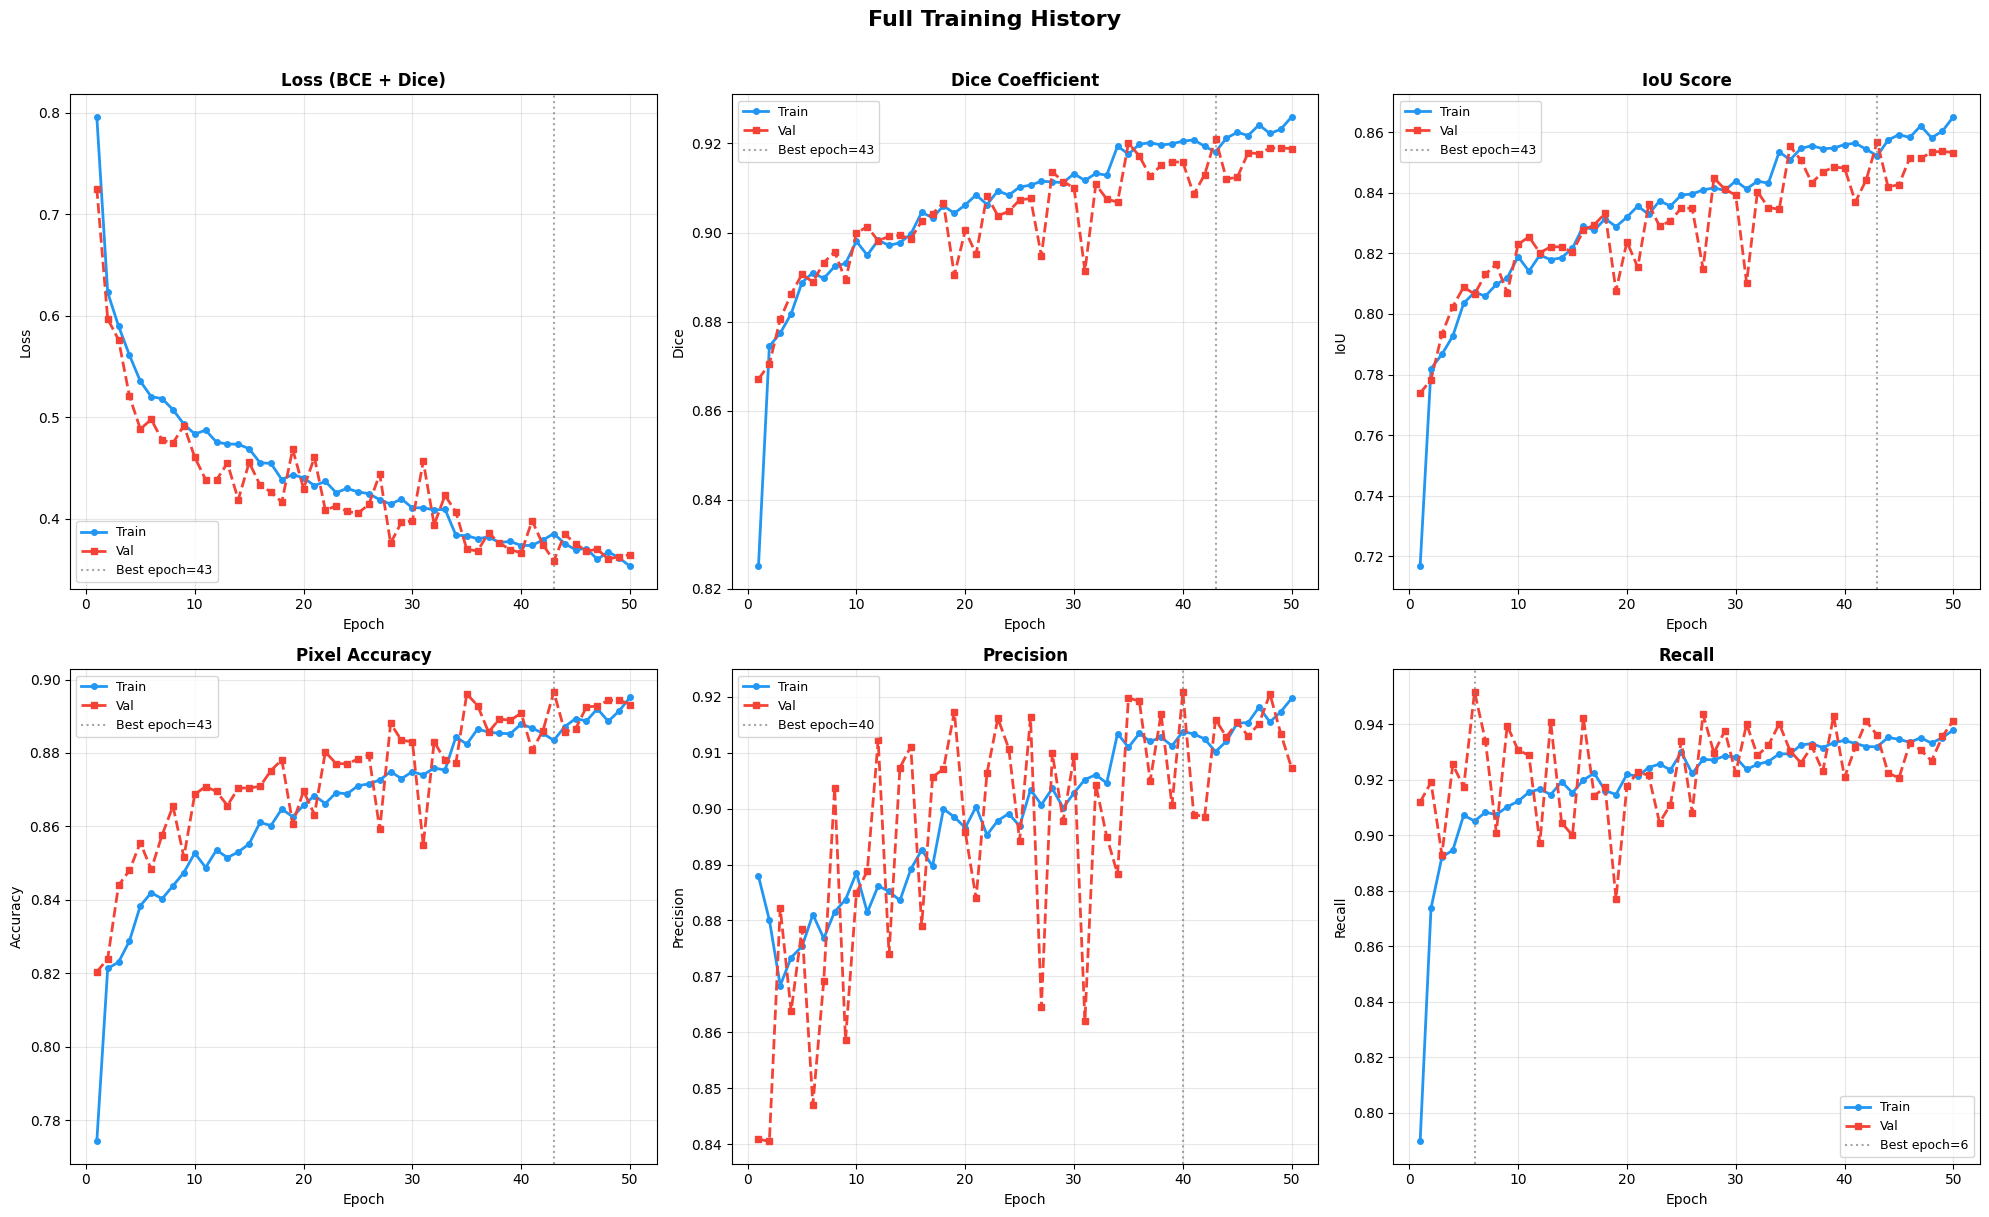

In [ ]:
hist         = history.history
epochs_range = range(1, len(hist["loss"]) + 1)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Full Training History", fontsize=16, fontweight="bold", y=1.01)

for ax, tk, vk, title, ylabel in [
    (axes[0,0], "loss",             "val_loss",             "Loss (BCE + Dice)",  "Loss"),
    (axes[0,1], "dice_coef_metric", "val_dice_coef_metric", "Dice Coefficient",    "Dice"),
    (axes[0,2], "iou_metric",        "val_iou_metric",       "IoU Score",           "IoU"),
    (axes[1,0], "accuracy",          "val_accuracy",          "Pixel Accuracy",      "Accuracy"),
    (axes[1,1], "precision",         "val_precision",         "Precision",           "Precision"),
    (axes[1,2], "recall",            "val_recall",            "Recall",              "Recall"),
]:
    ax.plot(epochs_range, hist[tk], label="Train", color="#2196F3", lw=2, marker="o", ms=4)
    ax.plot(epochs_range, hist[vk], label="Val",   color="#F44336", lw=2, marker="s", ms=4, ls="--")

    best_idx = np.argmax(hist[vk]) if "loss" not in vk else np.argmin(hist[vk])
    ax.axvline(best_idx + 1, color="gray", linestyle=":", alpha=0.7,
               label=f"Best epoch={best_idx+1}")

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Epoch"); ax.set_ylabel(ylabel)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "full_training_history.png"), dpi=150, bbox_inches="tight")
plt.show()

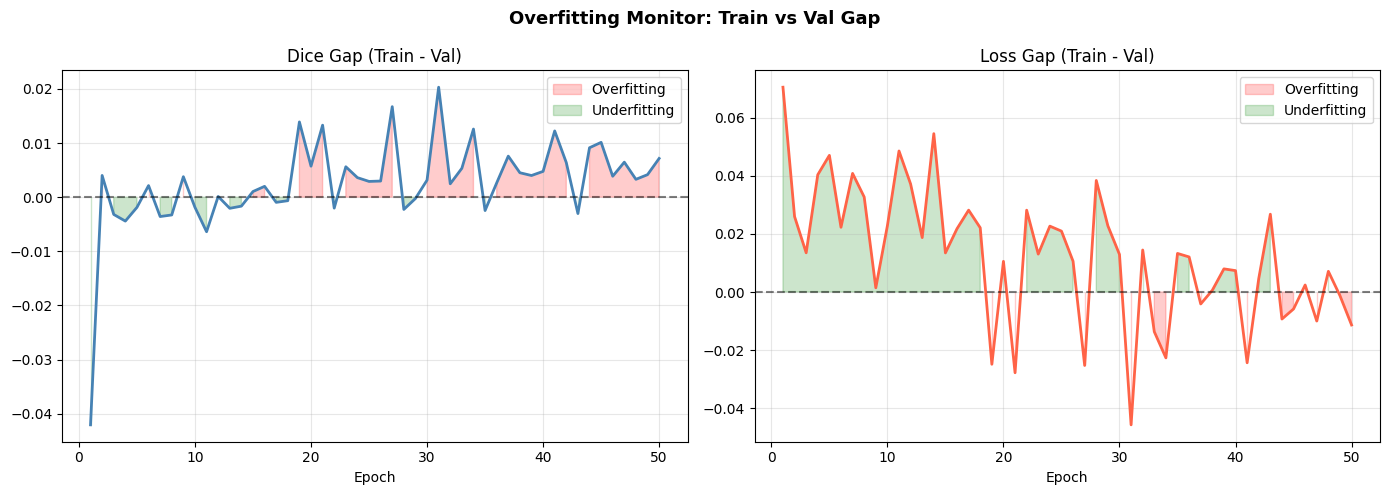

In [ ]:
# Learning rate schedule
if "lr" in hist:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.semilogy(epochs_range, hist["lr"], color="purple", lw=2, marker="o", ms=4)
    ax.set_title("Learning Rate Schedule", fontsize=13, fontweight="bold")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Learning Rate (log scale)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "lr_schedule.png"), dpi=150, bbox_inches="tight")
    plt.show()

# Overfitting monitor: train-val gap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Overfitting Monitor: Train vs Val Gap", fontsize=13, fontweight="bold")

dice_gap = np.array(hist["dice_coef_metric"]) - np.array(hist["val_dice_coef_metric"])
loss_gap = np.array(hist["loss"]) - np.array(hist["val_loss"])

axes[0].plot(epochs_range, dice_gap, color="steelblue", lw=2)
axes[0].axhline(0, color="black", linestyle="--", alpha=0.5)
axes[0].fill_between(epochs_range, 0, dice_gap,
                     where=(dice_gap > 0),  alpha=0.2, color="red",   label="Overfitting")
axes[0].fill_between(epochs_range, 0, dice_gap,
                     where=(dice_gap <= 0), alpha=0.2, color="green", label="Underfitting")
axes[0].set_title("Dice Gap (Train - Val)"); axes[0].set_xlabel("Epoch")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, loss_gap, color="tomato", lw=2)
axes[1].axhline(0, color="black", linestyle="--", alpha=0.5)
axes[1].fill_between(epochs_range, 0, loss_gap,
                     where=(loss_gap < 0),  alpha=0.2, color="red",   label="Overfitting")
axes[1].fill_between(epochs_range, 0, loss_gap,
                     where=(loss_gap >= 0), alpha=0.2, color="green", label="Underfitting")
axes[1].set_title("Loss Gap (Train - Val)"); axes[1].set_xlabel("Epoch")
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "overfitting_monitor.png"), dpi=150, bbox_inches="tight")
plt.show()

## 9. Evaluation on the Validation Set

The best checkpoint saved during training is loaded and evaluated across the entire validation split. Per-batch metrics are averaged to produce final Dice, IoU, accuracy, precision, recall, and F1 scores. Results are presented both as a printed table and as a horizontal bar chart for quick visual comparison.

In [ ]:
best_ckpt = os.path.join(OUTPUT_DIR, "best_model.h5")
model.load_weights(best_ckpt)
print(f"Loaded best checkpoint: {best_ckpt}")

def evaluate_model(model, image_paths, mask_paths, verbose=True):
    ds = make_dataset(image_paths, mask_paths, augment=False)
    all_dice, all_iou, all_acc, all_prec, all_rec = [], [], [], [], []

    for images, masks in ds:
        preds     = model.predict(images, verbose=0)
        preds_bin = tf.cast(preds > 0.5, tf.float32)
        smooth    = 1e-6

        tp = tf.reduce_sum(masks * preds_bin)
        fp = tf.reduce_sum((1 - masks) * preds_bin)
        fn = tf.reduce_sum(masks * (1 - preds_bin))

        union_dice = tf.reduce_sum(masks) + tf.reduce_sum(preds_bin)
        union_iou  = union_dice - tp

        all_dice.append(((2*tp + smooth) / (union_dice + smooth)).numpy())
        all_iou.append(((tp + smooth) / (union_iou + smooth)).numpy())
        all_acc.append(tf.reduce_mean(tf.cast(tf.equal(masks, preds_bin), tf.float32)).numpy())
        all_prec.append(((tp + smooth) / (tp + fp + smooth)).numpy())
        all_rec.append(((tp + smooth) / (tp + fn + smooth)).numpy())

    p = np.mean(all_prec)
    r = np.mean(all_rec)
    results = {
        "Dice Score": np.mean(all_dice),
        "IoU":        np.mean(all_iou),
        "Accuracy":   np.mean(all_acc),
        "Precision":  p,
        "Recall":     r,
        "F1 Score":   2 * p * r / (p + r + 1e-6),
    }

    if verbose:
        print("\n" + "="*42)
        print("  EVALUATION RESULTS (Validation Set)")
        print("="*42)
        for k, v in results.items():
            print(f"  {k:<14}: {v:.4f}")
        print("="*42)

    return results, all_dice, all_iou

eval_results, per_batch_dice, per_batch_iou = evaluate_model(model, val_images, val_masks)

Loaded best checkpoint: /kaggle/working/best_model.h5

  EVALUATION RESULTS (Validation Set)
  Dice Score    : 0.9211
  IoU           : 0.8570
  Accuracy      : 0.8967
  Precision     : 0.9106
  Recall        : 0.9363
  F1 Score      : 0.9233


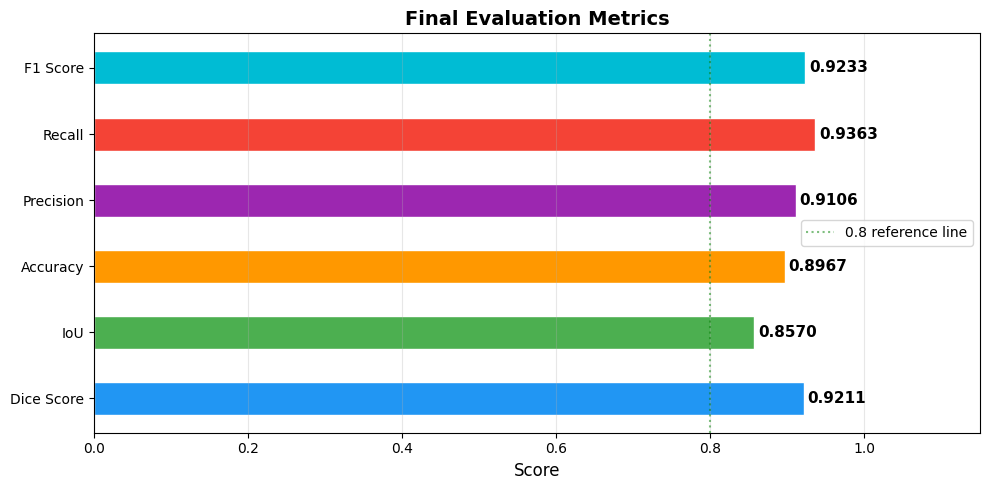

In [ ]:
# Metric bar chart
fig, ax = plt.subplots(figsize=(10, 5))
metric_names  = list(eval_results.keys())
metric_values = list(eval_results.values())
colors = ["#2196F3", "#4CAF50", "#FF9800", "#9C27B0", "#F44336", "#00BCD4"]

bars = ax.barh(metric_names, metric_values, color=colors, edgecolor="white", height=0.5)
for bar, val in zip(bars, metric_values):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f"{val:.4f}", va="center", fontsize=11, fontweight="bold")

ax.set_xlim(0, 1.15)
ax.set_xlabel("Score", fontsize=12)
ax.set_title("Final Evaluation Metrics", fontsize=14, fontweight="bold")
ax.axvline(0.8, color="green", linestyle=":", alpha=0.5, label="0.8 reference line")
ax.legend()
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "eval_metrics_bar.png"), dpi=150, bbox_inches="tight")
plt.show()

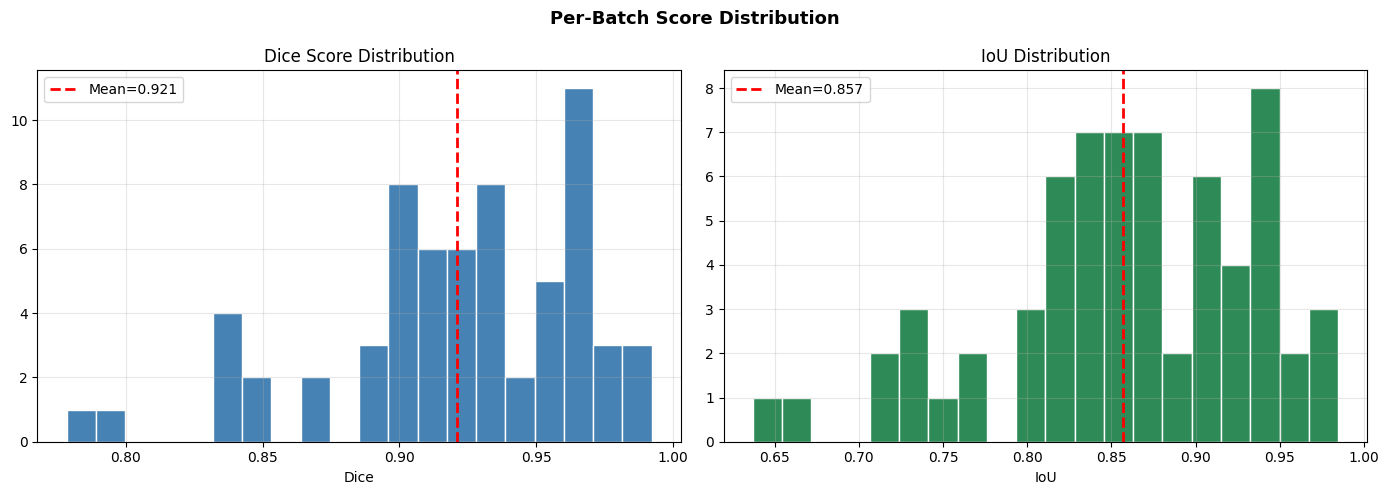

In [ ]:
# Per-batch Dice and IoU distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Per-Batch Score Distribution", fontsize=13, fontweight="bold")

axes[0].hist(per_batch_dice, bins=20, color="steelblue", edgecolor="white")
axes[0].axvline(np.mean(per_batch_dice), color="red", lw=2, linestyle="--",
                label=f"Mean={np.mean(per_batch_dice):.3f}")
axes[0].set_title("Dice Score Distribution"); axes[0].set_xlabel("Dice")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].hist(per_batch_iou, bins=20, color="seagreen", edgecolor="white")
axes[1].axvline(np.mean(per_batch_iou), color="red", lw=2, linestyle="--",
                label=f"Mean={np.mean(per_batch_iou):.3f}")
axes[1].set_title("IoU Distribution"); axes[1].set_xlabel("IoU")
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "score_distributions.png"), dpi=150, bbox_inches="tight")
plt.show()

## 10. Prediction Visualisations

Each row below shows five views of the same validation sample:

1. **Original image** -- the raw dermoscopy photograph.
2. **Ground truth** -- the expert-annotated binary mask.
3. **Prediction** -- the model's raw sigmoid output displayed with a plasma colourmap (darker regions indicate lower confidence).
4. **Overlay** -- the predicted mask highlighted in green on top of the original image.
5. **Error map** -- a colour-coded comparison where white marks true positives, red marks false positives, blue marks false negatives, and black marks true negatives.

The per-sample Dice score is printed alongside each row.

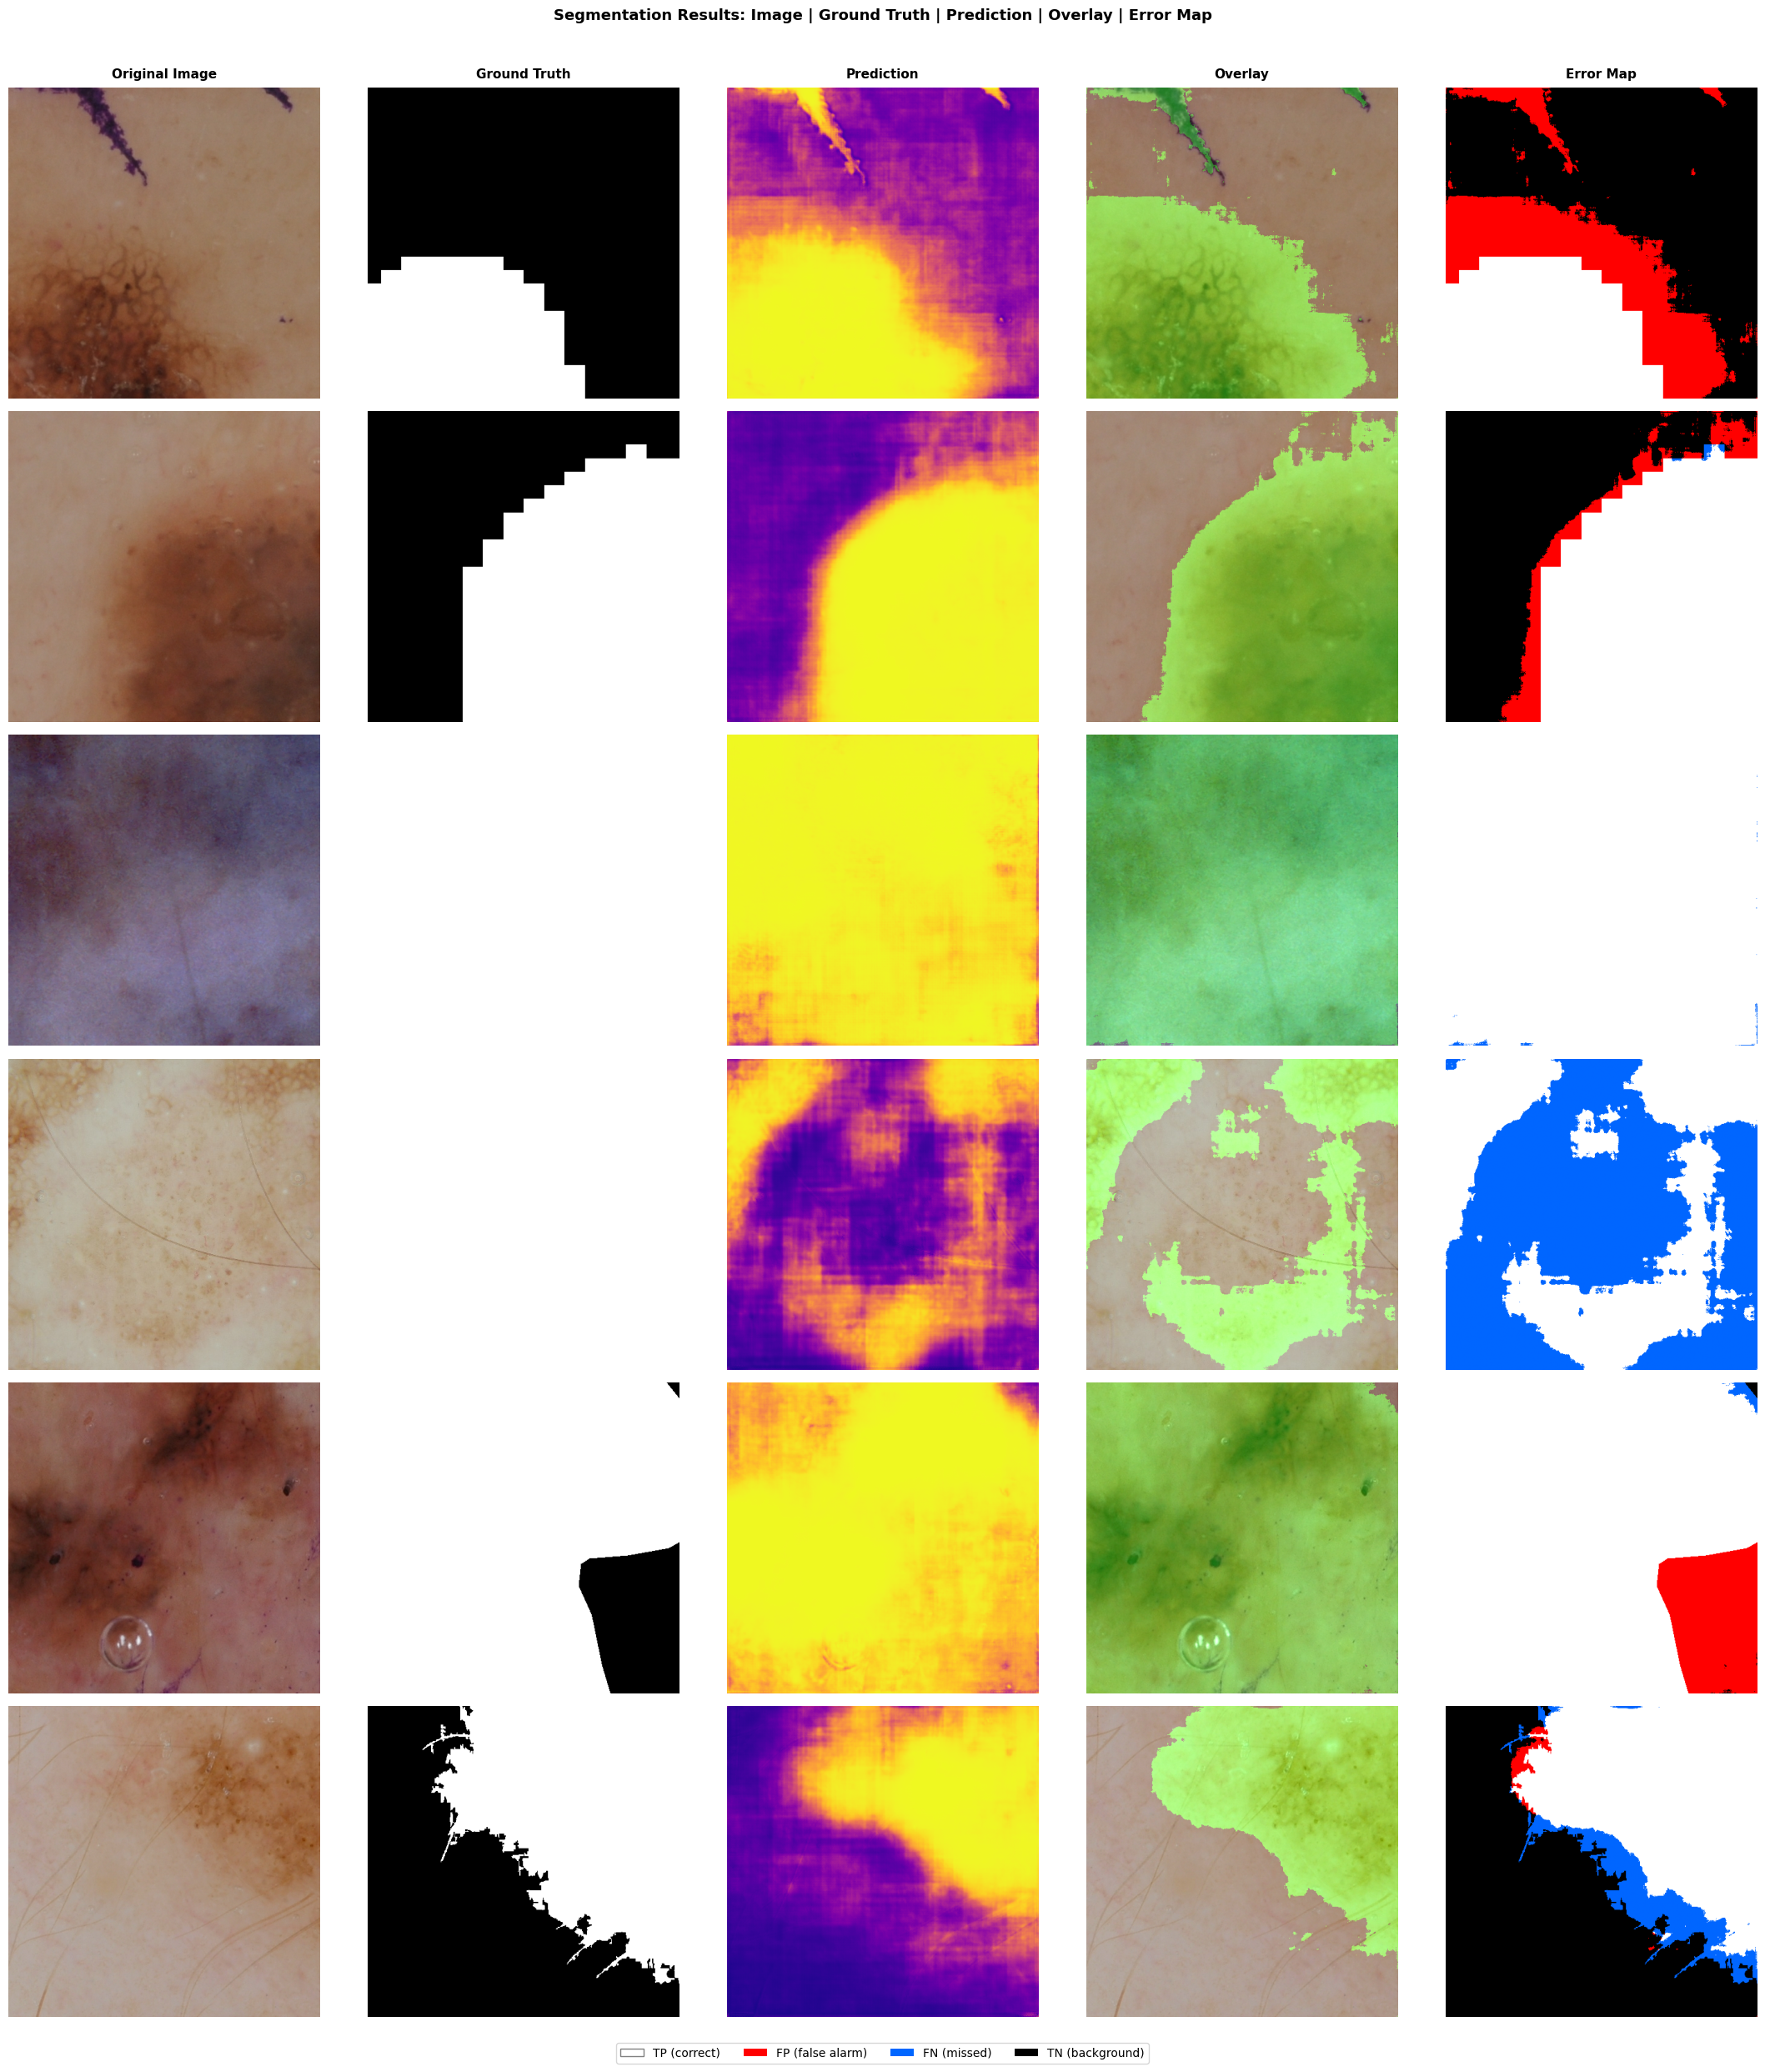

In [ ]:
def visualize_predictions(model, image_paths, mask_paths, num_samples=6):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    ds = ds.map(preprocess_val).batch(1)

    fig, axes = plt.subplots(num_samples, 5, figsize=(22, 4 * num_samples))
    fig.suptitle("Segmentation Results: Image | Ground Truth | Prediction | Overlay | Error Map",
                 fontsize=13, fontweight="bold", y=1.01)

    for col, title in enumerate(["Original Image", "Ground Truth",
                                  "Prediction", "Overlay", "Error Map"]):
        axes[0, col].set_title(title, fontsize=11, fontweight="bold", pad=8)

    for i, (image, mask) in enumerate(ds.take(num_samples)):
        pred     = model.predict(image, verbose=0)
        pred_bin = (pred[0, :, :, 0] > 0.5).astype(np.float32)
        img_np   = image[0].numpy()
        msk_np   = mask[0, :, :, 0].numpy()

        # Original image
        axes[i, 0].imshow(img_np); axes[i, 0].axis("off")

        # Ground truth mask
        axes[i, 1].imshow(msk_np, cmap="gray", vmin=0, vmax=1); axes[i, 1].axis("off")

        # Soft probability prediction
        axes[i, 2].imshow(pred[0, :, :, 0], cmap="plasma", vmin=0, vmax=1); axes[i, 2].axis("off")

        # Green overlay of predicted region
        overlay = img_np.copy()
        overlay[pred_bin == 1, 1] = np.clip(overlay[pred_bin == 1, 1] + 0.4, 0, 1)
        axes[i, 3].imshow(overlay); axes[i, 3].axis("off")

        # Error map: TP=white, FP=red, FN=blue, TN=black
        error_map = np.zeros((*msk_np.shape, 3))
        error_map[(msk_np == 1) & (pred_bin == 1)] = [1,   1,   1  ]   # TP white
        error_map[(msk_np == 0) & (pred_bin == 1)] = [1,   0,   0  ]   # FP red
        error_map[(msk_np == 1) & (pred_bin == 0)] = [0, 0.4,   1  ]   # FN blue
        axes[i, 4].imshow(error_map); axes[i, 4].axis("off")

        # Per-sample Dice label
        smooth = 1e-6
        dice   = (2*np.sum(msk_np*pred_bin)+smooth) / (np.sum(msk_np)+np.sum(pred_bin)+smooth)
        axes[i, 0].set_ylabel(f"Dice={dice:.3f}", fontsize=9, rotation=90, labelpad=5)

    from matplotlib.patches import Patch
    fig.legend(
        handles=[
            Patch(facecolor="white",  edgecolor="gray", label="TP (correct)"),
            Patch(facecolor="red",    label="FP (false alarm)"),
            Patch(facecolor="#0066ff", label="FN (missed)"),
            Patch(facecolor="black",  label="TN (background)"),
        ],
        loc="lower center", ncol=4, fontsize=10, bbox_to_anchor=(0.5, -0.02)
    )

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "prediction_grid.png"), dpi=120, bbox_inches="tight")
    plt.show()

visualize_predictions(model, val_images, val_masks, num_samples=6)

2026-02-24 13:20:35.925263: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-24 13:20:36.181064: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


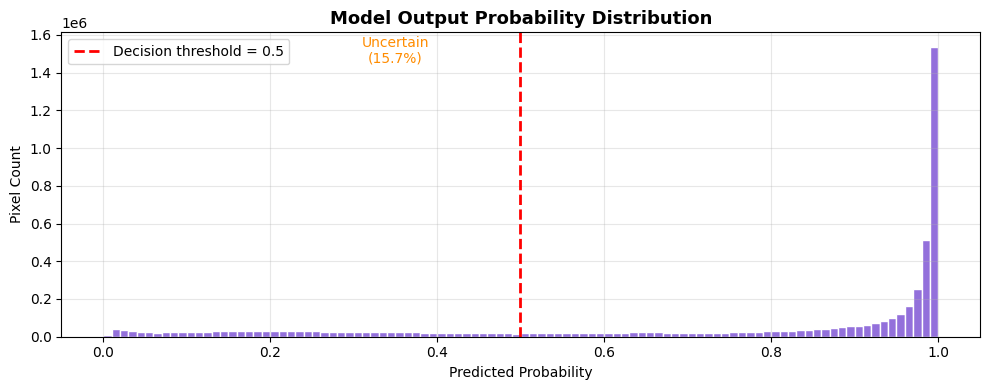

Pixels with uncertain probability (0.3-0.7): 15.7%


In [ ]:
# Model output probability distribution
# Shows how confident the model is across all pixels
all_probs = []
sample_ds = make_dataset(val_images[:20], val_masks[:20], augment=False)

for images, _ in sample_ds:
    preds = model.predict(images, verbose=0)
    all_probs.extend(preds.flatten().tolist())

all_probs = np.array(all_probs)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(all_probs, bins=100, color="mediumpurple", edgecolor="white")
ax.axvline(0.5, color="red", linestyle="--", lw=2, label="Decision threshold = 0.5")
ax.set_title("Model Output Probability Distribution", fontsize=13, fontweight="bold")
ax.set_xlabel("Predicted Probability")
ax.set_ylabel("Pixel Count")
ax.legend()
ax.grid(True, alpha=0.3)

low_conf = np.mean((all_probs > 0.3) & (all_probs < 0.7)) * 100
ax.text(0.35, ax.get_ylim()[1]*0.9, f"Uncertain\n({low_conf:.1f}%)",
        ha="center", color="darkorange", fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confidence_histogram.png"), dpi=150, bbox_inches="tight")
plt.show()
print(f"Pixels with uncertain probability (0.3-0.7): {low_conf:.1f}%")

## 11. Saving Results and Summary

All artefacts -- model weights, training history, evaluation metrics, and every plot generated above -- are written to disk. The summary table below recaps the best validation metrics achieved during training and the final evaluation scores.

In [ ]:
# Save training history as JSON
history_path = os.path.join(OUTPUT_DIR, "training_history.json")
history_serializable = {k: [float(v) for v in vals] for k, vals in hist.items()}
with open(history_path, "w") as f:
    json.dump(history_serializable, f, indent=2)
print(f"Training history saved: {history_path}")

# Save evaluation results as JSON
eval_path = os.path.join(OUTPUT_DIR, "eval_results.json")
with open(eval_path, "w") as f:
    json.dump({k: float(v) for k, v in eval_results.items()}, f, indent=2)
print(f"Eval results saved    : {eval_path}")

# Final summary
print("\n" + "="*50)
print("  FINAL TRAINING SUMMARY")
print("="*50)
print(f"  Total epochs trained : {len(hist['loss'])}")
print(f"  Best val Dice        : {max(hist['val_dice_coef_metric']):.4f}  (epoch {np.argmax(hist['val_dice_coef_metric'])+1})")
print(f"  Best val IoU         : {max(hist['val_iou_metric']):.4f}  (epoch {np.argmax(hist['val_iou_metric'])+1})")
print(f"  Best val Loss        : {min(hist['val_loss']):.4f}  (epoch {np.argmin(hist['val_loss'])+1})")
print("-"*50)
print(f"  Eval Dice Score      : {eval_results['Dice Score']:.4f}")
print(f"  Eval IoU             : {eval_results['IoU']:.4f}")
print(f"  Eval Accuracy        : {eval_results['Accuracy']:.4f}")
print(f"  Eval Precision       : {eval_results['Precision']:.4f}")
print(f"  Eval Recall          : {eval_results['Recall']:.4f}")
print(f"  Eval F1 Score        : {eval_results['F1 Score']:.4f}")
print("="*50)

print("\nSaved output files:")
saved_files = [
    "eda_stats.png", "eda_samples.png", "eda_class_balance.png",
    "augmentation_preview.png", "training_curves.png",
    "full_training_history.png", "lr_schedule.png",
    "overfitting_monitor.png", "eval_metrics_bar.png",
    "score_distributions.png", "prediction_grid.png",
    "confidence_histogram.png", "training_log.csv",
    "training_history.json", "eval_results.json", "best_model.h5",
]
for fname in saved_files:
    fpath  = os.path.join(OUTPUT_DIR, fname)
    status = "found" if os.path.exists(fpath) else "missing"
    print(f"  [{status}] {fpath}")

Training history saved: /kaggle/working/training_history.json
Eval results saved    : /kaggle/working/eval_results.json

  FINAL TRAINING SUMMARY
  Total epochs trained : 50
  Best val Dice        : 0.9211  (epoch 43)
  Best val IoU         : 0.8570  (epoch 43)
  Best val Loss        : 0.3588  (epoch 43)
--------------------------------------------------
  Eval Dice Score      : 0.9211
  Eval IoU             : 0.8570
  Eval Accuracy        : 0.8967
  Eval Precision       : 0.9106
  Eval Recall          : 0.9363
  Eval F1 Score        : 0.9233

Saved output files:
  [found] /kaggle/working/eda_stats.png
  [found] /kaggle/working/eda_samples.png
  [found] /kaggle/working/eda_class_balance.png
  [found] /kaggle/working/augmentation_preview.png
  [found] /kaggle/working/training_curves.png
  [found] /kaggle/working/full_training_history.png
  [missing] /kaggle/working/lr_schedule.png
  [found] /kaggle/working/overfitting_monitor.png
  [found] /kaggle/working/eval_metrics_bar.png
  [found] 